# Phase III: Analyzing severity of drift

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

2022-08-02 11:52:32.801252: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-02 11:52:32.806309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 11:52:32.806323: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.9.1'

In [2]:
tf.random.set_seed(42)

In [3]:
import numpy as np
np.__version__

'1.23.1'

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

# Step 1: Loading and exploring our data set
## Compare plots to reference data of newer iteration

In [5]:
import pandas as pd

iteration = 36

df = pd.read_csv(f'https://raw.githubusercontent.com/openknowledge/mlops-data2day/main/data/month-{iteration}.csv', delimiter=';')
# df = pd.read_csv(f'../data/month-{iteration}.csv', delimiter=';')

In [6]:
df.columns

Index(['training', 'age', 'emergency_breaking', 'braking_distance', 'power',
       'miles', 'risk', 'group_name', 'group'],
      dtype='object')

In [7]:
df.head()

training        age  emergency_breaking  braking_distance       power  \
0         0  45.700860                   1         33.730669  118.306787   
1         0  53.091268                   1         35.575746  168.151487   
2         1  41.989477                   1         37.515860  104.683894   
3         0  41.792728                   1         44.043184  143.531543   
4         1  28.679302                   1         34.329172   85.439495   

       miles      risk group_name  group  
0  92.429050 -0.812022        low      2  
1  53.595707  0.228346        low      2  
2  40.402020 -1.404598        low      2  
3  46.462029  0.668900        low      2  
4  39.791829 -1.694558        low      2

In [8]:
df.describe()

training          age  emergency_breaking  braking_distance  \
count  1500.000000  1500.000000         1500.000000       1500.000000   
mean      0.180667    39.438736            0.938667         40.051490   
std       0.384870    13.261725            0.240021          5.072253   
min       0.000000    19.786403            0.000000         22.509900   
25%       0.000000    28.474238            1.000000         36.687131   
50%       0.000000    36.935743            1.000000         40.342817   
75%       0.000000    47.503926            1.000000         43.311050   
max       1.000000    96.931120            1.000000         57.967082   

             power        miles         risk        group  
count  1500.000000  1500.000000  1500.000000  1500.000000  
mean    135.215854    62.765366     0.530990     1.622000  
std      35.950635    25.582015     1.301700     0.539732  
min      26.938595     5.000000    -3.827250     0.000000  
25%     109.462877    43.222911    -0.380678     1.000000  
50%     132.244743    58.121909     0.519117     2.000000  
75%     155.987021    79.320875     1.393983     2.000000  
max     284.698999   175.221602     5.532157     2.000000

In [9]:
import seaborn as sns

In [10]:
labels = ["High Risk", "Medium Risk", "Low Risk"]
markers = ['v', 'd', '^']
# colors = ['#FF8080', '#FFFF80', '#8080FF']
colors = ['#FF0000', '#FFFF00', '#0000FF']

In [11]:
features = ['training', 'age', 'emergency_breaking', 'braking_distance', 'power', 'miles', 'risk']

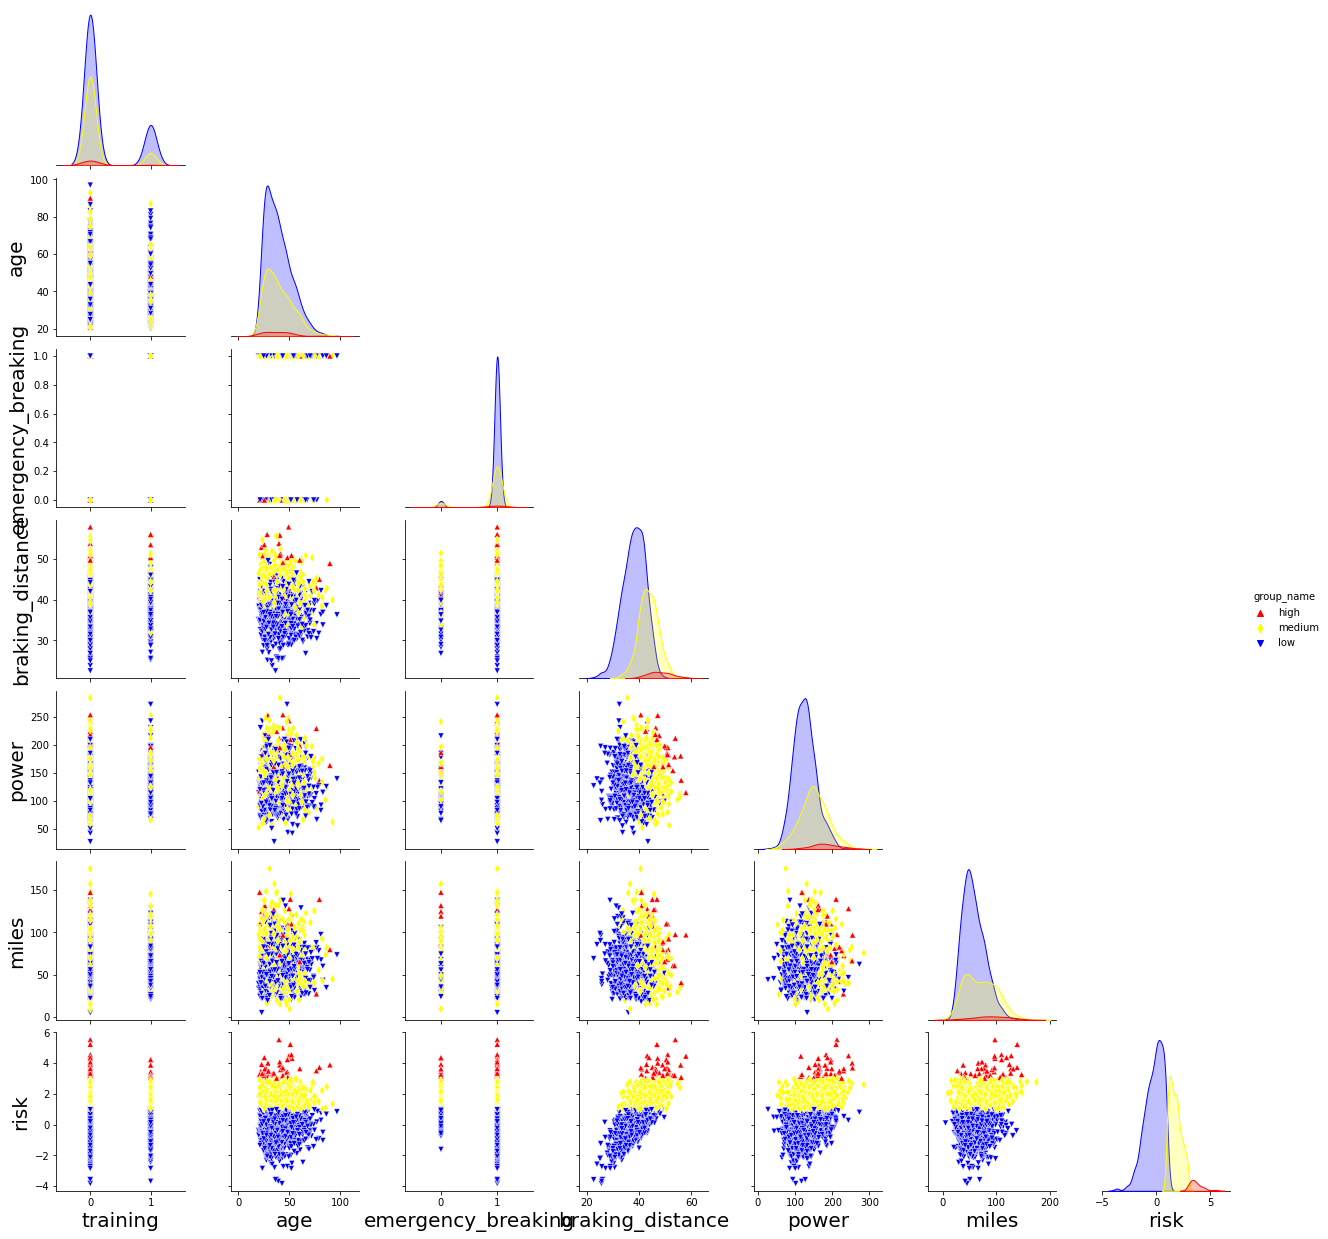

In [12]:
sns.pairplot(df, 
             kind="scatter", 
             diag_kind="kde",
             corner=True, 
             hue='group_name',
             hue_order = ['high', 'medium', 'low'],
             palette=colors, 
             markers=markers,
             vars=features);

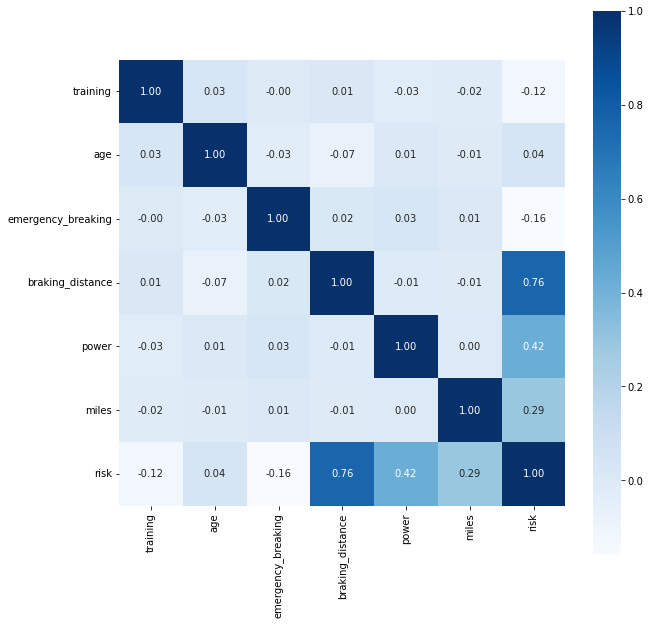

In [13]:
plt.figure(figsize=(10, 10))

cm = df.corr()
cm3 = cm.iloc[:len(features), :len(features)]

hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                cmap='Blues', 
                fmt='.2f',
                yticklabels=features,
                xticklabels=features)

# Step 2: Analyze for drift of input data

* https://docs.evidentlyai.com/reports/data-drift
* copied from
  * https://docs.evidentlyai.com/examples
  * https://github.com/evidentlyai/evidently/blob/main/examples/sample_notebooks/multiclass_target_and_data_drift_iris.ipynb

In [14]:
df_reference = pd.read_csv('https://raw.githubusercontent.com/openknowledge/mlops-data2day/main/data/reference.csv', delimiter=';')

In [15]:
df_X = df.drop(['risk', 'group', 'group_name'], axis='columns')
df_reference_X = df_reference.drop(['risk', 'group', 'group_name'], axis='columns')

In [16]:
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab
data_drift_dashboard = Dashboard(tabs=[DataDriftTab(verbose_level=1)])

In [17]:
df_reference_X.columns

Index(['training', 'age', 'emergency_breaking', 'braking_distance', 'power',
       'miles'],
      dtype='object')

In [18]:
# https://docs.evidentlyai.com/features/dashboards/column_mapping#column-mapping
from evidently.pipeline.column_mapping import ColumnMapping

column_mapping = ColumnMapping()
column_mapping.numerical_features = ['age', 'braking_distance', 'power', 'miles']
column_mapping.categorical_features = ['training', 'emergency_breaking'] 

In [19]:
data_drift_dashboard.calculate(df_reference_X, df_X, column_mapping)
data_drift_dashboard.show(mode="inline")

# Step 3: Using predictions of model (we have not GT)

In [20]:
model_path = 'classifier'
model = tf.keras.models.load_model(f'{model_path}.h5')

2022-08-02 11:52:41.420477: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-02 11:52:41.420533: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-02 11:52:41.420568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BEN73DP): /proc/driver/nvidia/version does not exist
2022-08-02 11:52:41.421024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
X = df_X
# X = df_reference_X.valuesg
y_pred = model.predict(X, verbose=0).argmax(axis=1)
df_prediction = X.copy()
df_prediction['pred'] = y_pred

In [22]:
X = df_reference_X
y_pred = model.predict(X, verbose=0).argmax(axis=1)
df_reference_prediction = X.copy()
df_reference_prediction['pred'] = y_pred

In [23]:
target_drift_dashboard = Dashboard(tabs=[CatTargetDriftTab(verbose_level=1)])

In [24]:
column_mapping.prediction = 'pred'

In [25]:
target_drift_dashboard.calculate(df_reference_prediction, df_prediction, column_mapping)
target_drift_dashboard.show(mode="inline")